<a href="https://colab.research.google.com/github/jawshan/CompNeuro_Summer2020/blob/master/Jawshan_summer_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Data retrival
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)


In [ ]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [ ]:
#@title Data loading
import numpy as np
import pandas as pd

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
dat = alldat[11]
#print(dat.keys())

In [ ]:
#@title Data Extraction


def extract_data(data, brain_area):
  row = {}
  row['mouse_name']     = data['mouse_name']
  row['num_v1_neurons'] = np.sum(data['brain_area']=='VISp')
  row['num_neurons'], row['num_trials'], row['num_time_bins'] = data['spks'].shape

  # Event times in seconds ∈ [0,2.5]  
  row['start_time']      = 0.0
  row['stim_onset_time'] = data['stim_onset']
  row['gocue_time']      = data['gocue']
  row['response_time']   = data['response_time']
  row['feedback_time']   = data['feedback_time']
  row['end_time']        = data['bin_size'] * row['num_time_bins']
  # Stimulus info : right and left stimulus contrasts ∈ [0,1] 
  row['contrast_right'] = data['contrast_right']
  row['contrast_left']  = data['contrast_left']
  
# Action and feedback info   
  # response (left,no-go,right) :  ∈ {-1,0,1}
  # feedback (-ve,+ve)          :  ∈ {-1,1}  
  row['response']        = data['response']
  row['feedback']        = data['feedback_type']
  row['binary_feedback'] = np.array(data['feedback_type'] == 1).astype(int)
  #@title Spikes

  ## Extracting spikes from neurons corresponding to specified region
  visp_indexes = np.argwhere(data['brain_area']==brain_area)
  reduced_neuron_spikes = np.squeeze(data['spks'][visp_indexes,:,:],1)  
  ## Reshaping spikes to have trials dimension first : #trials, #neurons, #time_bins 
  row['spikes'] = reduced_neuron_spikes.transpose(1,0,2)

  ## Convert spikes to time & spike count per trial
  row['spike_times'] = np.zeros_like(row['spikes']).astype(np.float16)
  ax1, ax2, ax3      = np.shape(row['spikes'])
  row['spike_count'] = np.zeros((ax1, ax2, 1)).astype(np.float16)
  correction         = 1/1000
  for i, trial in enumerate(row['spike_times']):
    for j, neuron in enumerate(row['spike_times'][i]):
      row['spike_count'][i][j] = np.sum(row['spikes'][i][j])
      spike_time_list          = [10 * bin if spike !=0 else 0 for bin, spike in enumerate(row['spikes'][i][j])]
      row['spike_times'][i][j] = np.array(spike_time_list).astype(np.float16)

  row['spikes_reordered'] = reduced_neuron_spikes
  return(row)

extracted_data = np.array(list(map(lambda data: extract_data(data, 'VISp'), alldat)))
#print(extracted_data[0]['spike_count'][0][30])


In [ ]:
'''for bin, spike in enumerate(extracted_data[0]['spikes'][0][0]):
  print(10 * bin) if spike !=0 else print('0') 
  '''

"for bin, spike in enumerate(extracted_data[0]['spikes'][0][0]):\n  print(10 * bin) if spike !=0 else print('0') \n  "

In [ ]:
#@title Data Table
time_cols = ['start_time','stim_onset_time','gocue_time','response_time','feedback_time','end_time']
id_cols  = ['mouse_name']
dim_cols = ['num_v1_neurons','num_neurons','num_trials','num_time_bins','spike_times']

cols = id_cols + dim_cols

df = pd.DataFrame.from_records(extracted_data, columns=cols)

df_v1 = df[df['num_v1_neurons'] > 0]
df_v1

,mouse_name,num_v1_neurons,num_neurons,num_trials,num_time_bins,spike_times
0,Cori,178,734,214,250,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 50.0, 0.0, 0.0, 0...."
2,Cori,114,619,228,250,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
3,Forssmann,39,1769,249,250,"[[[0.0, 10.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0..."
7,Hench,48,1156,250,250,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
9,Hench,105,1172,447,250,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
11,Lederberg,66,698,340,250,"[[[0.0, 10.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
13,Lederberg,42,756,268,250,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
19,Moniz,122,899,235,250,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
21,Muller,133,646,444,250,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
24,Radnitz,94,885,261,250,"[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


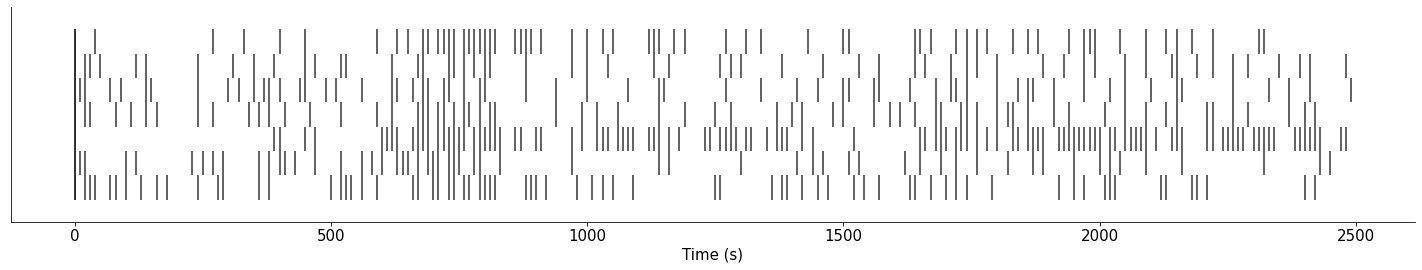

In [ ]:
#@title V1 data Raster plot
indexes_with_visp = np.array(df[df['num_v1_neurons']!=0].index)
extracted_data    = extracted_data[indexes_with_visp]
interval_spike_times = extracted_data[0]['spike_times'][0]
neuron_idx           = [idx for idx, neuron in enumerate(interval_spike_times) if len(neuron[neuron > 0]) > 50]

plt.eventplot(interval_spike_times[neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

In [ ]:
#@title logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

my_mouse             = extracted_data[5]
feedback             = my_mouse['binary_feedback']
spikes_my_mouse      = my_mouse['spikes_reordered']
trials, neurons, __, = np.shape(spikes_my_mouse)
trials               = [trial for trial in range(trials)]
neurons              = [neuron for neuron in range(neurons)]

neuron = 1

X = spikes_my_mouse[neuron][1:][:]
y = feedback[:-1]

# define model
log_reg = LogisticRegression(penalty="none")

# fit model to data
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

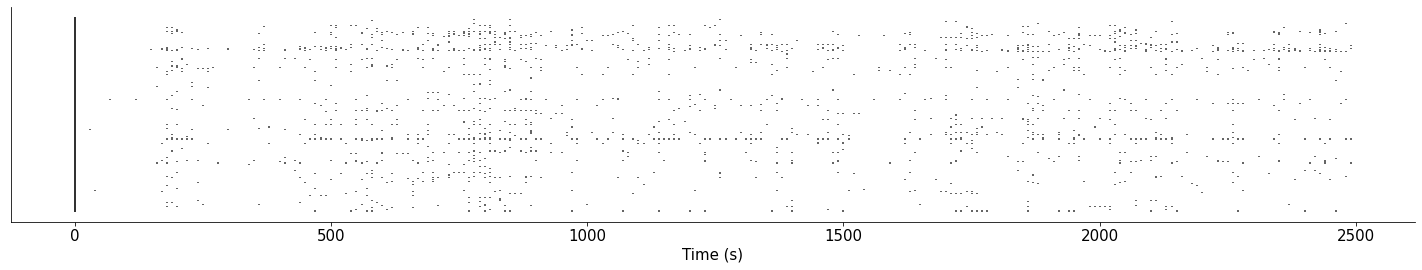

In [ ]:
#@title logistic regression (Neuron+trial)

interval_spike_times = extracted_data[0]['spike_times']
neuron_idx           = 30
trials, __, __       = np.shape(interval_spike_times)
trials               = np.arange(0, trials, 1).tolist()

plt.eventplot(interval_spike_times[trials][neuron_idx], color=".2")
plt.xlabel("Time (s)")
plt.yticks([]);

In [ ]:
#@title cross validation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

my_mouse             = extracted_data[0]
feedback             = my_mouse['binary_feedback']
spikes_my_mouse      = my_mouse['spikes_reordered']
trials, neurons, __, = np.shape(spikes_my_mouse)
trials               = [trial for trial in range(trials)]
neurons              = [neuron for neuron in range(neurons)]

neuron = 1

X = spikes_my_mouse[neuron][1:][:]
y = feedback[:-1]

# define model
log_reg = LogisticRegression(penalty="none")

# fit model to data
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
#@title computing accuracy
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.
  Returns:
    accuracy (float): Proportion of correct predictions.  
  """
  y_pred = model.predict(X)
  accuracy = (y == y_pred).mean()

  return accuracy

train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")



Accuracy on the training data: 73.71%
